In [1]:
import json
import keyword
import unicodedata
from collections import defaultdict
import pandas as pd
from extract import SocialETL,Count, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
from rich import print
from rich.console import Console
from rich.progress import track
from rich.table import Table

from pathlib import Path
import random
import numpy as np
from extract import extract_tags
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## HASHTAG COUNTS

### #ProUcraina

In [22]:
c1=Count(query="#slavaukraini")
print(c1)

Output()

Count(query='#slavaukraini', df=pd.DataFrame, count=419065)

In [23]:
c2=Count(query="#IStandWithUkraine")
print(c2)

Output()

Count(query='#IStandWithUkraine', df=pd.DataFrame, count=609660)

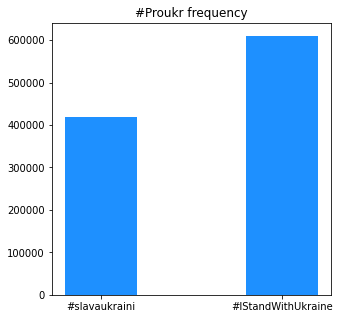

In [24]:
cat=[c1.query,c2.query]
values=[c1.count, c2.count]
fig=plt.figure(figsize=(5,5))
plt.bar(cat,values, width=0.4, color='dodgerblue')
plt.title('#Proukr frequency')
plt.show()

### #PaxRomana

In [25]:
c3=Count(query="#stopwarinukraine")
print(c3)

Output()

Count(query='#stopwarinukraine', df=pd.DataFrame, count=322045)

In [26]:
c4=Count(query="#stoprussia")
print(c4)

Output()

Count(query='#stoprussia', df=pd.DataFrame, count=1657226)

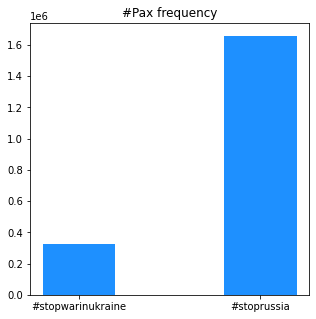

In [27]:
cat=[c3.query,c4.query]
values=[c3.count, c4.count]
fig=plt.figure(figsize=(5,5))
plt.bar(cat,values, width=0.4, color='dodgerblue')
plt.title('#Pax frequency')
plt.show()

### #ProRussia 

In [28]:
c5=Count(query="#ZelenskyWarCriminal")
print(c5)

Output()

Count(query='#ZelenskyWarCriminal', df=pd.DataFrame, count=6268)

In [29]:
c6=Count(query="#istandwithputin")
print(c6)

Output()

Count(query='#istandwithputin', df=pd.DataFrame, count=255117)

In [30]:
c7=Count(query="#istandwithrussia")
print(c7)

Output()

Count(query='#istandwithrussia', df=pd.DataFrame, count=140710)

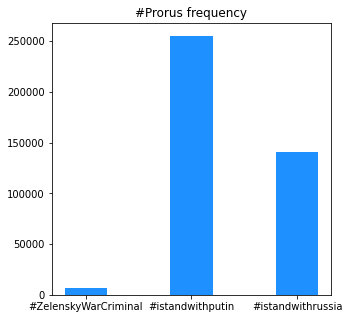

In [31]:
cat=[c5.query,c6.query, c7.query]
values=[c5.count,c6.count,c7.count]
fig=plt.figure(figsize=(5,5))
plt.bar(cat,values, width=0.4, color='dodgerblue')
plt.title('#Prorus frequency')
plt.show()

## Store hashtags into `twee_hash_800.csv`

In [2]:
def ensure_latin(s):
    return (
        unicodedata.normalize("NFKD", s).encode("latin-1", "ignore").decode("latin-1")
    )


def construct_query_for_pandas(root_tags: list) -> str:
    my_query = " or ".join(root_tags)
    return my_query


def create_score(df: pd.DataFrame, one_hashtag: str, root_tags: dict) -> list:
    # takes a df of all tweets, each row is a tweet, each column is
    # a hashtag either [True | False] depending on whether the hashtag
    # is in the tweet. Takes one_hashtag, the hashtag to score, and
    # root_tags, a dict of {category: [hashtags]}
    # TODO: make it so it accepts a list of {category: [hashtags]} instead of just one
    threshold_support = 0.9 * len(df) / 10000  # set the threshold_support here!!

    if threshold_support < 1:
        threshold_support = 1
    # print(f"Looking for {one_hashtag} with support {threshold_support}…")
    mask = df[one_hashtag]
    df = df[mask]
    # print(f"I found {len(df)} tweets with {one_hashtag}")
    if len(df) < threshold_support:
        return False
    """for col in df:
        if df[col].any():
            print(f"We have {col} hashtag")"""
    results = []
    # START OF TESTING:
    """    print(df.info())
    print(df.describe())
    print(df.head())
    print(f"[purple]Dude, here's the breakdown:")
    for tag in root_tags.values():
        print(f"[blue]This is {tag[0]}:")
        print(df[tag[0]])"""
    for category, tag_madre in root_tags.items():
        try:
            my_query = construct_query_for_pandas(tag_madre)
            # print(f"The pandas query is: [red]{my_query}")
            temp_df = df.query(my_query)
            # print(f"Holy jezuz: {len(temp_df)} and {len(df)}")
            results.append(round(len(temp_df) / len(df), 4))
        except KeyError:
            results.append(0)

    # print(results)
    return (results, len(df))


def do_search(tagmadre, pages):
    # construct the initial query to Twarc
    query_madre = construct_query_for_twarc(tagmadre)
    m = SocialETL(
        query=f"({query_madre})",
        pages=pages,
        recent=False,
    )

    # dropping any tweets with no hashtags (I think)
    tweets_with_hashtag = m.df[["id", "entities.hashtags"]].dropna()
    print(
        f"{len(m.df)} tweets retrieved\nwith query '{query_madre}'\nof which {len(tweets_with_hashtag)} tweets with at least 1 hashtag."
    )

    # evaluate the string in "entities.hashtags" to an actual list of dicts
    tweets_with_hashtag["entities.hashtags"] = tweets_with_hashtag[
        "entities.hashtags"
    ].map(eval)

    # make a simple list of strings, one hashtag is one string, into column "tags"
    tweets_with_hashtag["tags"] = tweets_with_hashtag["entities.hashtags"].map(
        extract_tags
    )
    tweets_with_hashtag = tweets_with_hashtag.drop(columns="entities.hashtags")

    # hashtags: EXPLODE *musica dei power ranger*
    all_hashtags = set(tweets_with_hashtag["tags"].explode())

    # keyword level: eliminate all python keywords from columns because otherwise we are in no man's land
    keywordsss = keyword.kwlist
    keywordsss.extend(keyword.softkwlist)
    all_hashtags = all_hashtags.difference(keywordsss)
    all_hashtags = all_hashtags.difference(set(("",)))

    print(f"We have {len(all_hashtags)} unique hashtags.")

    tweets_with_hashtag.set_index("id", inplace=True)

    col_h = sorted(list(all_hashtags))
    df_h = pd.DataFrame(columns=col_h)
    tweets_with_hashtag = pd.concat([tweets_with_hashtag, df_h], axis=1)
    tweets_with_hashtag = tweets_with_hashtag.fillna(False)

    def assign_hashtag_to_tweet(row: pd.Series) -> pd.Series:
        for tag in row["tags"]:
            if tag in all_hashtags:
                row.loc[tag] = True
        return row

    tweets_with_hashtag = tweets_with_hashtag.apply(assign_hashtag_to_tweet, axis=1)
    tweets_with_hashtag = tweets_with_hashtag.drop(columns=["tags"])

    for madre in tagmadre.values():
        print(f"[red]Let's write the describe of column '{madre[0]}'")
        print(tweets_with_hashtag[madre[0]].describe())

    tweets_with_hashtag.to_csv(f"twee_hash_{pages}.csv")
    print("[green]All done.")


if __name__ == "__main__":
    # params
    top_results_to_take = 3
    pages_to_do = 800

    # set the initial "parent" hashtags for each category
    tag_madre = {
        "proukr": ["slavaukraini"],
        "prorus": ["istandwithputin"],
        "pax": ["stopwarinukraine"],
    }

    # code
    # first run
    do_search(tag_madre, pages_to_do)


Reading secret from /Users/fabio/repos/sna/data/my_secrets.yaml…

Output()

74475 tweets retrieved
with query '#slavaukraini OR #istandwithputin OR #stopwarinukraine'
of which 74454 tweets with at least 1 hashtag.

We have 8845 unique hashtags.

Let's write the describe of column 'slavaukraini'

count     74454
unique        2
top        True
freq      47003
Name: slavaukraini, dtype: object

Let's write the describe of column 'istandwithputin'

count     74454
unique        2
top       False
freq      70468
Name: istandwithputin, dtype: object

Let's write the describe of column 'stopwarinukraine'

count     74454
unique        2
top       False
freq      49966
Name: stopwarinukraine, dtype: object

All done.

## Categorization of hashtags stored in `twee_hash_800.csv` and creation of two .json: `hashtags_800.json`, `supports_800.json`

In [3]:
df=pd.read_csv('twee_hash_800.csv')

In [ ]:
df.shape

In [ ]:
df.head(10)

In [4]:
def do_search(tagmadre, pages):
    # construct the initial query to Twarc
    tweets_with_hashtag = pd.read_csv(Path("twee_hash_800.csv"), index_col=0)

    # hashtags: EXPLODE *musica dei power ranger*
    all_hashtags = set(tweets_with_hashtag.columns)

    # keyword level: eliminate all python keywords from columns because otherwise we are in no man's land
    keywordsss = keyword.kwlist
    keywordsss.extend(keyword.softkwlist)
    all_hashtags = all_hashtags.difference(keywordsss)
    all_hashtags = all_hashtags.difference(set(("",)))

    # up to here we have only dealt with a dataframe of tweets. Now we switch to dataframe of hashtags

    # create a dataframe with all hashtags and their scores
    all_hashtags_as_dict = {}
    supp = {}
    for hashtag in track(all_hashtags):
        # discard based on support
        pass
        # calculate scores only on hashtags with enough support
        score = create_score(tweets_with_hashtag, hashtag, tagmadre)
        if score is not False:
            # score[0] is the scores, score[1] is the support
            all_hashtags_as_dict[hashtag] = score[0]
            supp[hashtag] = score[1]
    all_hashtags_df = pd.DataFrame.from_dict(
        all_hashtags_as_dict, orient="index", columns=tagmadre
    )

    # now, "categorize" hashtags. The hashtag gets the category of its max score,
    # as long as it is > `threshold_certainty`
    # TODO: remember that we still need to account for hashtag support
    # (i.e. number of tweets supporting that hashtag)
    threshold_certainty = 0.4
    tags_categorized = defaultdict(list)
    for hashtag, scores in all_hashtags_df.iterrows():
        # print(hashtag, scores)  # TODO: check if the scores are different enough among 3 categories
        # print(scores.idxmax(), scores.max())
        if scores.max() > threshold_certainty:
            tags_categorized[scores.idxmax()].append((hashtag, scores.max()))
            other_scores = set(scores).difference(set((scores.max(),)))
            for sco in other_scores:
                if scores.max() < 1.2 * sco:
                    print(f"Attention. For {hashtag} the scores are\n{scores}")

    # tags_categorized.sort(key=lambda x: x[1], reverse=True)
    """    tags_categorized = {
        k: sorted(v, key=lambda item: item[1], reverse=True)
        for k, v in tags_categorized.items()
    }"""

    return tags_categorized, supp


if __name__ == "__main__":
    # params
    top_results_to_take = 3
    pages_to_do = 800

    # set the initial "parent" hashtags for each category
    tag_madre = {
        "proukr": ["slavaukraini"],
        "prorus": ["istandwithputin"],
        "pax": ["stopwarinukraine"],
    }

    # code
    # first run
    end_results, tags_support = do_search(tag_madre, pages_to_do)

    # second run
    """
    end_results = {
        k: [x[0] for x in v[:top_results_to_take]] for k, v in end_results.items()
    }
    print("miao", end_results)
    end_results = do_search(end_results)
    """

    with open(f"hashtags_{pages_to_do}.json", "w", encoding="utf-8") as f:
        json.dump(end_results, f, ensure_ascii=False, indent=4)
    with open(f"supports_{pages_to_do}.json", "w", encoding="utf-8") as f:
        json.dump(tags_support, f, ensure_ascii=False, indent=4)

Output()

Attention. For stophatingrussians the scores are
proukr    0.0696
prorus    0.4696
pax       0.4609
Name: stophatingrussians, dtype: float64

Attention. For music the scores are
proukr    0.4773
prorus    0.0000
pax       0.5227
Name: music, dtype: float64

Attention. For prayforukraine the scores are
proukr    0.4761
prorus    0.0021
pax       0.5468
Name: prayforukraine, dtype: float64

Attention. For cancelrussia the scores are
proukr    0.4583
prorus    0.0000
pax       0.5417
Name: cancelrussia, dtype: float64

Attention. For putinwarcriminal the scores are
proukr    0.5147
prorus    0.0048
pax       0.4983
Name: putinwarcriminal, dtype: float64

Attention. For solidaritywithukraine the scores are
proukr    0.4815
prorus    0.0000
pax       0.5185
Name: solidaritywithukraine, dtype: float64

Attention. For standwithukrain the scores are
proukr    0.5385
prorus    0.0000
pax       0.4615
Name: standwithukrain, dtype: float64

Attention. For ukraineunderattak the scores are
proukr    0.4890
prorus    0.1263
pax       0.4208
Name: ukraineunderattak, dtype: float64

Attention. For closetheskyoverukrainenow the scores are
proukr    0.5319
prorus    0.0000
pax       0.5000
Name: closetheskyoverukrainenow, dtype: float64

Attention. For fakenews the scores are
proukr    0.2083
prorus    0.3750
pax       0.4167
Name: fakenews, dtype: float64

Attention. For ukraineunderattack the scores are
proukr    0.4833
prorus    0.0357
pax       0.4822
Name: ukraineunderattack, dtype: float64

Attention. For russia the scores are
proukr    0.4884
prorus    0.1051
pax       0.4081
Name: russia, dtype: float64

Attention. For mariupol the scores are
proukr    0.4505
prorus    0.0248
pax       0.5270
Name: mariupol, dtype: float64

Attention. For putinhuilo the scores are
proukr    0.4773
prorus    0.0000
pax       0.5227
Name: putinhuilo, dtype: float64

Attention. For ukrainerussiawar the scores are
proukr    0.5028
prorus    0.0772
pax       0.4353
Name: ukrainerussiawar, dtype: float64

Attention. For defendukraine the scores are
proukr    0.5333
prorus    0.0000
pax       0.4889
Name: defendukraine, dtype: float64

Attention. For russianaggression the scores are
proukr    0.5312
prorus    0.0000
pax       0.4688
Name: russianaggression, dtype: float64

Attention. For itarmyofukraine the scores are
proukr    0.9041
prorus    0.0000
pax       1.0000
Name: itarmyofukraine, dtype: float64

Attention. For noflyzoneoverukraine the scores are
proukr    0.8152
prorus    0.0000
pax       0.7376
Name: noflyzoneoverukraine, dtype: float64

Attention. For russianukrainianwar the scores are
proukr    0.1952
prorus    0.4397
pax       0.3718
Name: russianukrainianwar, dtype: float64

Attention. For protectusky the scores are
proukr    0.5161
prorus    0.0000
pax       0.4839
Name: protectusky, dtype: float64

Attention. For vladimirputingenocide the scores are
proukr    0.4667
prorus    0.0000
pax       0.5333
Name: vladimirputingenocide, dtype: float64

Attention. For ukranian the scores are
proukr    0.450
prorus    0.075
pax       0.475
Name: ukranian, dtype: float64

Attention. For ukraineresistance the scores are
proukr    1.000
prorus    0.000
pax       0.875
Name: ukraineresistance, dtype: float64

Attention. For madrid the scores are
proukr    0.5517
prorus    0.0000
pax       0.5172
Name: madrid, dtype: float64

Attention. For stopputinswar the scores are
proukr    0.4597
prorus    0.0044
pax       0.5447
Name: stopputinswar, dtype: float64

Attention. For hitler the scores are
proukr    0.50
prorus    0.05
pax       0.45
Name: hitler, dtype: float64

In [8]:
with open(f'hashtags_800.json', 'r') as f:
    final_dict = json.load(f)

    table = Table(title="# of hashtags final lists")

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("# of hashtags", justify="right", style="red", no_wrap=True)


for k, v in final_dict.items():
    table.add_row(str(k), str(len(v)))

console = Console()
console.print(table)

 # of hashtags final lists  
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Category ┃ # of hashtags ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ proukr   │           781 │
│ pax      │           621 │
│ prorus   │           152 │
└──────────┴───────────────┘

In [9]:
final_dict

{'proukr': [['nftshill', 0.9],
  ['slovakia', 0.6667],
  ['downwithimperialistputin', 1.0],
  ['volodymyrzelenskyy', 0.8966],
  ['ukrainerussianwar', 0.4766],
  ['slovenija', 1.0],
  ['vlodomyrzelenskyy', 1.0],
  ['holodomor', 1.0],
  ['fbsi', 1.0],
  ['ukrainetoday', 0.9],
  ['fuckrussia', 0.9773],
  ['stopputler', 0.5455],
  ['traitorstodemocracy', 0.5714],
  ['slavaukraini', 1.0],
  ['traumafokus', 1.0],
  ['strasbourg', 1.0],
  ['freeivanfedorov', 0.6667],
  ['cnntonight', 1.0],
  ['fckrussia', 1.0],
  ['zelenskyyisahero', 0.9487],
  ['westandwithukrain', 0.9],
  ['kharkiv', 0.5387],
  ['tory', 1.0],
  ['volodymyr', 1.0],
  ['presidentzelenskyy', 1.0],
  ['paix', 0.6364],
  ['ukrainianheroes', 0.9],
  ['fucputin', 0.625],
  ['resistputin', 0.9957],
  ['overthrowputin', 0.9333],
  ['savethechildren', 0.9667],
  ['assad', 0.8889],
  ['ukrainewillwin', 0.9796],
  ['glorytoukraine', 0.9136],
  ['sundaymorning', 0.9412],
  ['putinmustfail', 1.0],
  ['support', 0.6923],
  ['russiagohome'

## Removal of *"neutral"* hashtags

In [ ]:
with open('hashtags_800.json', 'r') as f:
    my_dict = json.load(f)
my_dict

In [ ]:
table = Table(title="# of hashtags found")

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("# of hashtags", justify="right", style="red", no_wrap=True)


for k, v in my_dict.items():
    table.add_row(str(k), str(len(v)))
    
console = Console()
console.print(table)

In [ ]:
my_dict_copy=my_dict.copy()

In [ ]:
#lista di hahstags che sono palesemente IDONTCARE
remove_hash_set= set(['watch','nftcommunity','contemporaryart','sisterhoodforever','cryptoartist','arte','cigar','oilpaintings','drewdiplomat','lgbtq','bonvoyage','transally','tabak','avanticondraghi','artshare','tabakespecial','ourbodiesourchoice','yemencantwait','climatecrisis','beautiful','google','catsontwitter','karma','bbc','artwork','mustread','freesyria','taiwanisnotchina','johnsonout170','dove','backboris','clouds','cats','manifesta14prishtina','31luglio','nowsmoking','bastille','mondaymorning','coffee','punk','14juillet','billsmafia','ilustration','etc','infosec','drawingart','music','metaverse','naturephotography','johnsonout174','1988massacre','badass','cybersecurity','monochrome','newprofilepic','mariodraghi','redcarpet','summer','visitkotkahamina','landscape','eurovision','iostocondraghi','error404','retwit','research','cbdnft','sunflowers','kittyloafmonday','cryptoart','nft','amazing','voteblue2022','eurovision2023','cigarlife','brexithasfailed','blog','graziepresidentedraghi','fantastic','poems','poet','cityphotography','facciamorete','cityscape','catsoftwittter','catlover','elezioni2022','climateemergency','freeiran','animals','nftcollectors','problem','catlovers','sea','nftartist','blacklivesmatter','whateverittakes','fresh','medvedev','toriesout22','standwithboris','dogsoftwitter','toriesout25','followbackfriday','tshirt','cutepets','gracias','lgbt','art','boots','salvini','boycottleroymerlin','macron','sketch','fuckserbia','figurativepainting','500px','rammstein','oilpainting','banassaultweaponsnow','crowdfunding','retweeet','catsoftwitter','spotify','toriesout15','draw','mondaythoughts','voteblue','womensrightsarehumanrights','pentesting','nfts','vogue','tiktok','blackandwhitephoto','water','nightvision','pentagon','cybersec','glory','lifestyle','animalrescue','kindnessismagic','catslover','throwbackthursday','twitter','cbdoil','caturday','nftcollector','ford','biden','ourbluevoice','flashlights','14juillet2022','mybodymychoice','highlandparkstrong','covidisnotover','photography','boxing','splendidfeet','nftshills','covid19','collageart','frexit','streaming','nftjapan','phrases','nftproject','oscars','cocaino','cryptocurrency','ai','artistoninstagram','artistsontwitter','promotion','painting','graffiti','nftcommumity','ballerina','eyes','lyrik','collagen','nftnyc2022','mariopaciolla','hollywood','mothersday','aiart','indie','giulioregeni','iphone','nftartwork','nftcollections','sexymonday','happymothersday2022','covid_19','youtuber','collageartwork','imaginedragons','bidenlsalaughingstock',])
#lista di hashtags "neutrali" posizioni geografiche 
remove2_hash_set= set(['polish','lithuania','ucraine','romaniaukraine','milano','georgia','minsk','estonia','crimea','mariupol','ukrain','odesa','azerbaijan','ukrania','moskau','bielorussia','paris','syria','norway','buffalo','finland','germany','donbass','india','mosca','chicago','ohio','odessa','ucraina','kiev','moscow','france','kharkiv','northvancouver','europe','lettland','chaplynka','europa','italia','olenivka','texas','africa','vancouver','turkey','afghanistan','berlin','usa','tallinn','california','uk','switzerland','northkorea','japan','chinataiwan','australia',])

In [ ]:
#hashtags in "neutrali" che riguardano luoghi della guerra
#'ucraine','romaniaukraine','crimea','mariupol','ukrain','odesa','ukrania','moskau','donbass','mosca','odessa','ucraina','kiev','moscow','kharkiv','chaplynka','olenivka',

In [ ]:
remove=set.union(remove_hash_set, remove2_hash_set)
for i in remove:
    for k,v in my_dict_copy.items():
        for e in v:
            #print(v)
            if e[0] == i:
                v.remove(e)

In [5]:
table = Table(title="# of hashtags found")

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("# of hashtags", justify="right", style="red", no_wrap=True)


for k, v in my_dict.items():
    table.add_row(str(k), str(len(v)))

console = Console()
console.print(table)

    # of hashtags found     
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Category ┃ # of hashtags ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ proukr   │           743 │
│ pax      │           584 │
│ prorus   │           146 │
└──────────┴───────────────┘

## Write of the final .json: `hashtags_final.json`

In [ ]:
with open(f"hashtags_final.json", "w", encoding="utf-8") as f:
        json.dump(my_dict_copy, f, ensure_ascii=False, indent=4)

In [ ]:
#magia nera

In [3]:
with open(f'hashtags_final.json', 'r') as f:
    my_dict = json.load(f)
my_dict

{'proukr': [['nftshill', 0.9],
  ['slovakia', 0.6667],
  ['downwithimperialistputin', 1.0],
  ['volodymyrzelenskyy', 0.8966],
  ['ukrainerussianwar', 0.4766],
  ['slovenija', 1.0],
  ['vlodomyrzelenskyy', 1.0],
  ['holodomor', 1.0],
  ['fbsi', 1.0],
  ['ukrainetoday', 0.9],
  ['fuckrussia', 0.9773],
  ['stopputler', 0.5455],
  ['traitorstodemocracy', 0.5714],
  ['slavaukraini', 1.0],
  ['traumafokus', 1.0],
  ['strasbourg', 1.0],
  ['freeivanfedorov', 0.6667],
  ['cnntonight', 1.0],
  ['fckrussia', 1.0],
  ['zelenskyyisahero', 0.9487],
  ['westandwithukrain', 0.9],
  ['tory', 1.0],
  ['volodymyr', 1.0],
  ['presidentzelenskyy', 1.0],
  ['paix', 0.6364],
  ['ukrainianheroes', 0.9],
  ['fucputin', 0.625],
  ['resistputin', 0.9957],
  ['overthrowputin', 0.9333],
  ['savethechildren', 0.9667],
  ['assad', 0.8889],
  ['ukrainewillwin', 0.9796],
  ['glorytoukraine', 0.9136],
  ['sundaymorning', 0.9412],
  ['putinmustfail', 1.0],
  ['support', 0.6923],
  ['russiagohome', 0.6471],
  ['sotb', 1

In [ ]:
with open(f'hashtags_300.json', 'r') as f:
    my_dict2 = json.load(f)
#my_dict2

In [ ]:
table = Table(title="# of hashtags found")

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("# of hashtags", justify="right", style="red", no_wrap=True)


for k, v in my_dict2.items():
    table.add_row(str(k), str(len(v)))

console = Console()
console.print(table)

In [ ]:
for k,v in my_dict.items():
    for k2,v2 in my_dict2.items():
        for vs in v2:
            if k=='prorus' and k2=='prorus':
                v.append(vs)

In [ ]:
table = Table(title="# of hashtags found")

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("# of hashtags", justify="right", style="red", no_wrap=True)


for k, v in my_dict.items():
    table.add_row(str(k), str(len(v)))

console = Console()
console.print(table)

In [ ]:
with open(f"hashtag_final_lists.json", "w", encoding="utf-8") as f:
    json.dump(my_dict, f, ensure_ascii=False, indent=4)

 # of hashtags final lists  
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Category ┃ # of hashtags ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ proukr   │           781 │
│ pax      │           621 │
│ prorus   │           152 │
└──────────┴───────────────┘

### Word Cloud

In [53]:
with open(f'hashtag_final_lists.json', 'r') as f:
    my_dict = json.load(f)
with open(f'supports_800.json','r')as f:
    count = json.load(f)


In [56]:
my_dict

{'proukr': [['nftshill', 0.9],
  ['slovakia', 0.6667],
  ['downwithimperialistputin', 1.0],
  ['volodymyrzelenskyy', 0.8966],
  ['ukrainerussianwar', 0.4766],
  ['slovenija', 1.0],
  ['vlodomyrzelenskyy', 1.0],
  ['holodomor', 1.0],
  ['fbsi', 1.0],
  ['ukrainetoday', 0.9],
  ['fuckrussia', 0.9773],
  ['stopputler', 0.5455],
  ['traitorstodemocracy', 0.5714],
  ['slavaukraini', 1.0],
  ['traumafokus', 1.0],
  ['strasbourg', 1.0],
  ['freeivanfedorov', 0.6667],
  ['cnntonight', 1.0],
  ['fckrussia', 1.0],
  ['zelenskyyisahero', 0.9487],
  ['westandwithukrain', 0.9],
  ['tory', 1.0],
  ['volodymyr', 1.0],
  ['presidentzelenskyy', 1.0],
  ['paix', 0.6364],
  ['ukrainianheroes', 0.9],
  ['fucputin', 0.625],
  ['resistputin', 0.9957],
  ['overthrowputin', 0.9333],
  ['savethechildren', 0.9667],
  ['assad', 0.8889],
  ['ukrainewillwin', 0.9796],
  ['glorytoukraine', 0.9136],
  ['sundaymorning', 0.9412],
  ['putinmustfail', 1.0],
  ['support', 0.6923],
  ['russiagohome', 0.6471],
  ['sotb', 1

In [57]:
count

{'nftshill': 10,
 'melitopil': 42,
 'politics': 8,
 'onu': 11,
 'stopthewar': 1215,
 'slovakia': 12,
 'downwithimperialistputin': 18,
 'europeanparliament': 13,
 'volodymyrzelenskyy': 29,
 'ukrainerussianwar': 898,
 'paris': 27,
 'stopviolenceagainstwomen': 13,
 'slovenija': 8,
 'vlodomyrzelenskyy': 8,
 'belarus': 329,
 'holodomor': 18,
 'fbsi': 58,
 'seebruecke': 70,
 'ukrainetoday': 10,
 'children': 20,
 'cronaca': 21,
 'donneinarte': 7,
 'stophatingrussians': 230,
 'fuckrussia': 44,
 'stopputler': 11,
 'traitorstodemocracy': 7,
 'slavaukraini': 47003,
 'russieukraine': 36,
 'traumafokus': 17,
 'strasbourg': 43,
 'otancriminal': 48,
 'iaea': 24,
 'freeivanfedorov': 15,
 'cnntonight': 7,
 'fckrussia': 7,
 'staywithukraine': 137,
 'stopbombingdonbass': 35,
 'stopbusinessinrussia': 208,
 'zelenskyyisahero': 39,
 'peaceplease': 8,
 'westandwithukrain': 30,
 'kharkiv': 362,
 'stopputinwarcrimesnow': 31,
 'tory': 9,
 'volodymyr': 8,
 'follow': 10,
 'presidentzelenskyy': 14,
 'paix': 11,
 '

In [58]:
hash_proukr=[]
hash_prorus=[]
hash_pax=[]
for k,h in my_dict.items(): 
    for e in h:
        for k_c,v in count.items():
            if k=='proukr' and k_c==e[0]:
                hash_proukr.append((k_c,)*v)
            elif k=='prorus' and k_c==e[0]:
                hash_prorus.append((k_c,)*v)
            elif k=='pax' and k_c==e[0]:
                hash_pax.append((k_c,)*v)

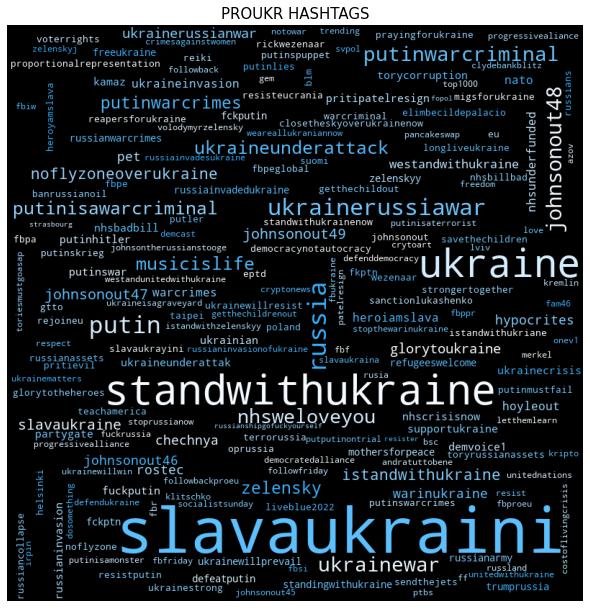

In [76]:
text = ''
stopwords = set(STOPWORDS)
for liste in hash_proukr:
    for el in liste:
        #cloud_proukr.append(l)
        text += ''.join(str(e) for e in el)+','

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10,
                collocations=False).generate(text)
 
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.title('PROUKR HASHTAGS', fontsize=15)
plt.show()

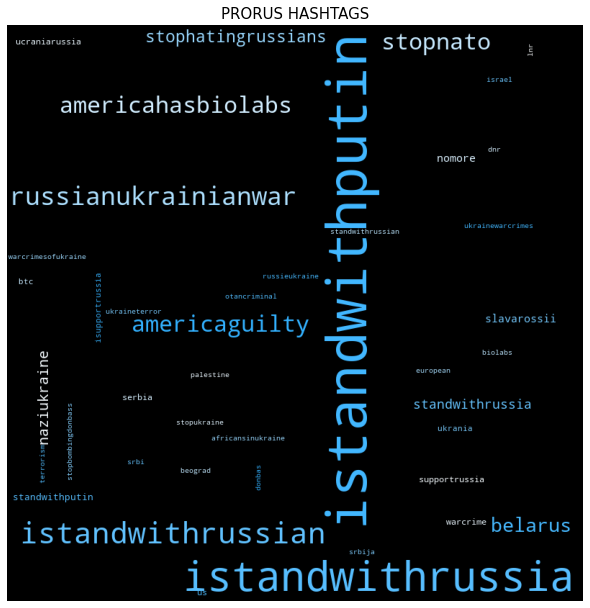

In [75]:
text = ''
stopwords = set(STOPWORDS)
for liste in hash_prorus:
    for el in liste:
        #cloud_proukr.append(l)
        text += "".join(str(e) for e in el)+',' 

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10,
                collocations=False).generate(text)

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(203, 100%%, %50d%%)" % random.randint(60, 100)  

wordcloud.recolor(color_func = grey_color_func)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 58), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.title('PRORUS HASHTAGS', fontsize=15)
plt.show()

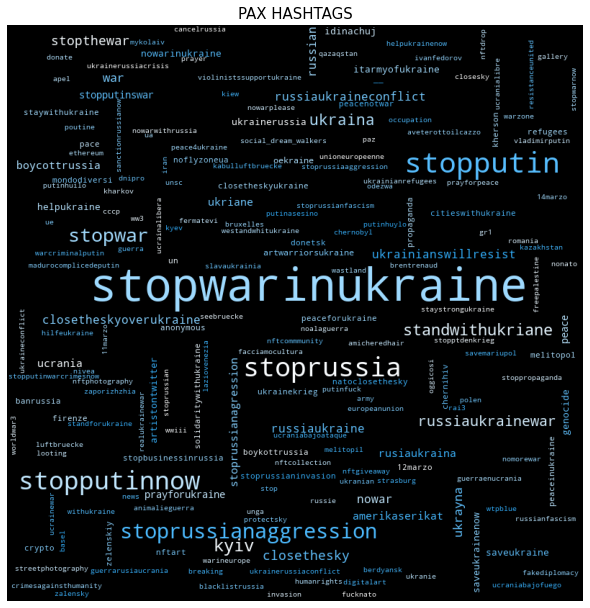

In [83]:
text = ''
stopwords = set(STOPWORDS)
for liste in hash_pax:
    for el in liste:
        #cloud_proukr.append(l)
        text += "".join(str(e) for e in el)+',' 

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10,
                     collocations=False).generate(text)
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.title('PAX HASHTAGS', fontsize=15)
plt.show()